# Introduction to Computer Vision: Plant Seedlings Classification

## Problem Statement

### Context

In recent times, the field of agriculture has been in urgent need of modernizing, since the amount of manual work people need to put in to check if plants are growing correctly is still highly extensive. Despite several advances in agricultural technology, people working in the agricultural industry still need to have the ability to sort and recognize different plants and weeds, which takes a lot of time and effort in the long term. The potential is ripe for this trillion-dollar industry to be greatly impacted by technological innovations that cut down on the requirement for manual labor, and this is where Artificial Intelligence can actually benefit the workers in this field, as **the time and energy required to identify plant seedlings will be greatly shortened by the use of AI and Deep Learning.** The ability to do so far more efficiently and even more effectively than experienced manual labor, could lead to better crop yields, the freeing up of human inolvement for higher-order agricultural decision making, and in the long term will result in more sustainable environmental practices in agriculture as well.


### Objective

The aim of this project is to Build a Convolutional Neural Netowrk to classify plant seedlings into their respective categories.

### Data Dictionary

The Aarhus University Signal Processing group, in collaboration with the University of Southern Denmark, has recently released a dataset containing **images of unique plants belonging to 12 different species.**

- The dataset can be download from Olympus.
- The data file names are:
    - images.npy
    - Label.csv
- Due to the large volume of data, the images were converted to the images.npy file and the labels are also put into Labels.csv, so that you can work on the data/project seamlessly without having to worry about the high data volume.

- The goal of the project is to create a classifier capable of determining a plant's species from an image.

**List of Species**

- Black-grass
- Charlock
- Cleavers
- Common Chickweed
- Common Wheat
- Fat Hen
- Loose Silky-bent
- Maize
- Scentless Mayweed
- Shepherds Purse
- Small-flowered Cranesbill
- Sugar beet

####**Note: Please use GPU runtime to execute the code efficiently**

## Importing necessary libraries

In [ ]:
!pip install scikeras

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import cv2
import seaborn as sns


# Tensorflow modules
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam,SGD
from scikeras.wrappers import KerasClassifier, KerasRegressor
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelBinarizer
# Display images using OpenCV
from google.colab.patches import cv2_imshow
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend
from keras.callbacks import ReduceLROnPlateau
import random
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

## Loading the dataset

In [ ]:
# Mount Google drive to access the dataset
# Run the below code if you using google colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Loading the image files
images = np.load('/content/drive/My Drive/Data/compvision/images.npy')

# Loading the labels
labels = pd.read_csv('/content/drive/My Drive/Data/compvision/Labels.csv')

## Data Overview

### Understand the shape of the dataset

In [ ]:
# Check shape of images and labels
print(images.shape)
print(labels.shape)

(4750, 128, 128, 3)
(4750, 1)


There are 4,750 RGB images in 128px X 128px resolution.
For the labels, there are 4,750 labels--one for each of the images.

## Exploratory Data Analysis

- EDA is an important part of any project involving data.
- It is important to investigate and understand the data better before building a model with it.
- A few questions have been mentioned below which will help you understand the data better.
- A thorough analysis of the data, in addition to the questions mentioned below, should be done.

1. How are these different category plant images different from each other?
2. Is the dataset provided an imbalance? (Check with using bar plots)

In [ ]:
def plot_images(images,labels):
  num_classes=10                                                                  # Number of Classes
  categories=np.unique(labels)
  keys=dict(labels['Label'])                                                      # Obtaing the unique classes from y_train
  rows = 3                                                                        # Defining number of rows=3
  cols = 4                                                                        # Defining number of columns=4
  fig = plt.figure(figsize=(10, 8))                                               # Defining the figure size to 10x8
  for i in range(cols):
      for j in range(rows):
          random_index = np.random.randint(0, len(labels))                        # Generating random indices from the data and plotting the images
          ax = fig.add_subplot(rows, cols, i * rows + j + 1)                      # Adding subplots with 3 rows and 4 columns
          ax.imshow(images[random_index, :])                                      # Plotting the image
          ax.set_title(keys[random_index])
  plt.show()

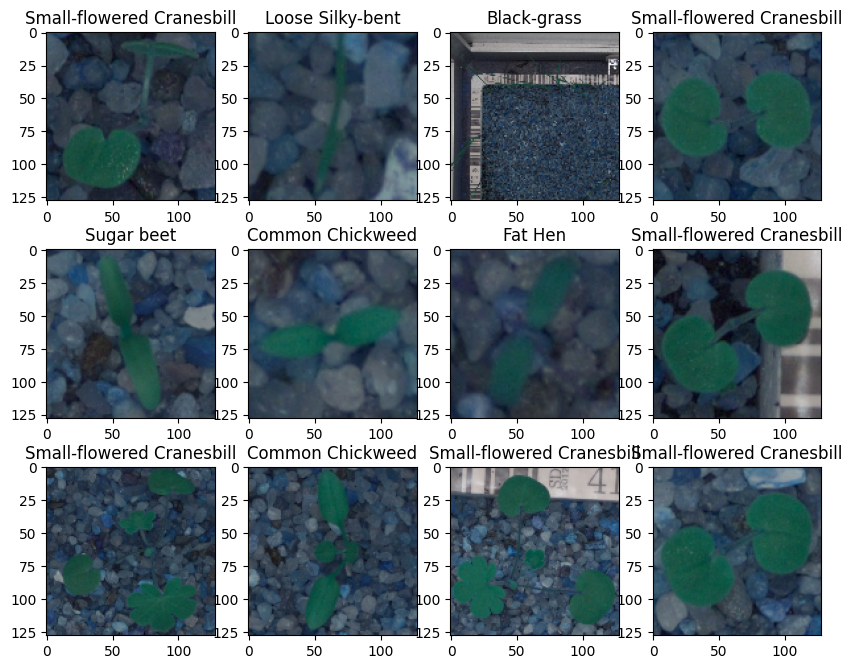

In [ ]:
# Display images with labels
plot_images(images, labels)

###Labels - EDA

In [ ]:
# Check first 5 rows of the labels file
labels.head()

Label
0  Small-flowered Cranesbill
1  Small-flowered Cranesbill
2  Small-flowered Cranesbill
3  Small-flowered Cranesbill
4  Small-flowered Cranesbill

As expected, this file contains only 1 columns ['Label']. We'll check for missing or incorrect values.

In [ ]:
# Check for Missing Values
missing_values = labels.isnull().sum()
print(missing_values)

Label    0
dtype: int64


There are no missing values.

In [ ]:
# Get # of occurances for each value in the dataset
label_counts = labels['Label'].value_counts()
label_counts

Loose Silky-bent             654
Common Chickweed             611
Scentless Mayweed            516
Small-flowered Cranesbill    496
Fat Hen                      475
Charlock                     390
Sugar beet                   385
Cleavers                     287
Black-grass                  263
Shepherds Purse              231
Common wheat                 221
Maize                        221
Name: Label, dtype: int64

There are 12 labels and no duplicate or supicious values.

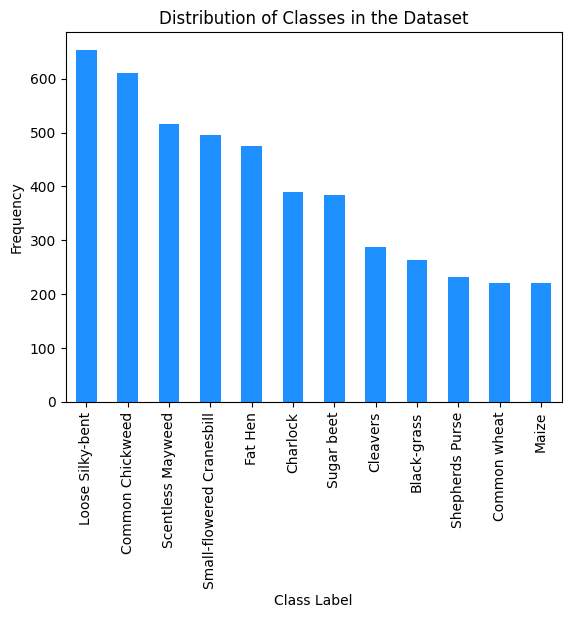

In [ ]:
# Plot barchart of label occurances
label_counts.plot(kind='bar', color='dodgerblue')
plt.xlabel('Class Label')
plt.ylabel('Frequency')
plt.title('Distribution of Classes in the Dataset')
plt.show()

###Images - EDA

In [ ]:
''' This function shows 5 random images from
    the defined plant type label '''

def show_images(plant_type):
    # Filter images and labels for the specified plant type
    plant_filter = labels['Label'] == plant_type
    filtered_images = images[plant_filter]
    filtered_labels = labels[plant_filter]

    # Define the number of images to display
    num_images = 5

    # Create the figure with a specific size
    fig = plt.figure(figsize=(10, 8))

    # Loop to display 4 random images of the specified plant type
    for i in range(num_images):
        if len(filtered_labels) == 0:
            print(f"No images found for plant type '{plant_type}'")
            return

        random_index = np.random.randint(0, len(filtered_labels))
        ax = fig.add_subplot(1, num_images, i + 1)  # 1 row, 4 columns
        ax.imshow(filtered_images[random_index, :])
        ax.set_title(plant_type)
        ax.axis('off')

        # Adjust subplot parameters if necessary
    plt.tight_layout()  # This can help to fit everything neatly

    plt.show()

In [ ]:
# Select a random image and display it's array properties
random_index = np.random.randint(len(images))
random_image_array = images[random_index]
print(random_image_array)

# Find the average intensity value of the image
average_intensity = np.mean(random_image_array)
print("")
print(f"The average intensity of the image is: {average_intensity}")

[[[ 69  83  92]
  [ 66  79  91]
  [ 65  78  89]
  ...
  [ 83 109 125]
  [ 76 106 120]
  [ 56  84 100]]

 [[ 64  82  86]
  [ 60  80  87]
  [ 63  81  89]
  ...
  [ 80 102 118]
  [ 55  80  98]
  [ 52  76  96]]

 [[ 21  68  57]
  [ 29  69  63]
  [ 44  76  77]
  ...
  [ 79  96 112]
  [ 67  90 104]
  [ 58  82 100]]

 ...

 [[ 42  40  49]
  [ 49  42  54]
  [ 46  45  54]
  ...
  [ 41  39  47]
  [ 43  45  52]
  [ 49  49  57]]

 [[ 47  45  53]
  [ 47  45  55]
  [ 49  47  53]
  ...
  [ 41  41  50]
  [ 46  47  56]
  [ 43  43  51]]

 [[ 42  40  48]
  [ 48  45  52]
  [ 46  45  48]
  ...
  [ 42  41  51]
  [ 46  46  55]
  [ 45  46  50]]]

The average intensity of the image is: 66.07497151692708


The array denotes the pixel intensity for each of the image's pixels. Note that in the random image selected, the AVERAGE pixel intensity has been displayed.

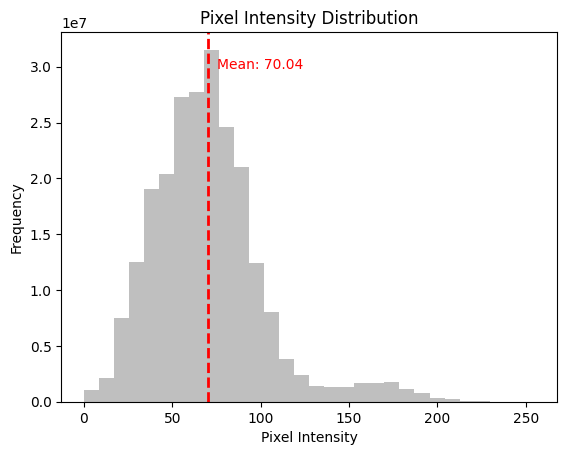

In [ ]:
''' Function to analyze the intensity of
    pixels in the image dataset '''

def plot_pixel_intensity_distribution(images):
    # Flatten the images to a list of pixels
    pixels = images.flatten()

    # Calculate the mean of the pixel intensities
    mean_intensity = np.mean(pixels)

    # Plot the histogram
    plt.hist(pixels, bins=30, range=[0,255], color='gray', alpha=0.5)

    # Plot the mean line
    plt.axvline(mean_intensity, color='red', linestyle='dashed', linewidth=2)
    plt.text(mean_intensity + 5, plt.ylim()[1] * 0.9, f'Mean: {mean_intensity:.2f}', color = 'red')

    # Set the titles and labels
    plt.title('Pixel Intensity Distribution')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')

    # Show the plot
    plt.show()

plot_pixel_intensity_distribution(images)

The average pixel intensity for the images is 70.4 with intensity ranging from 0 to 225.

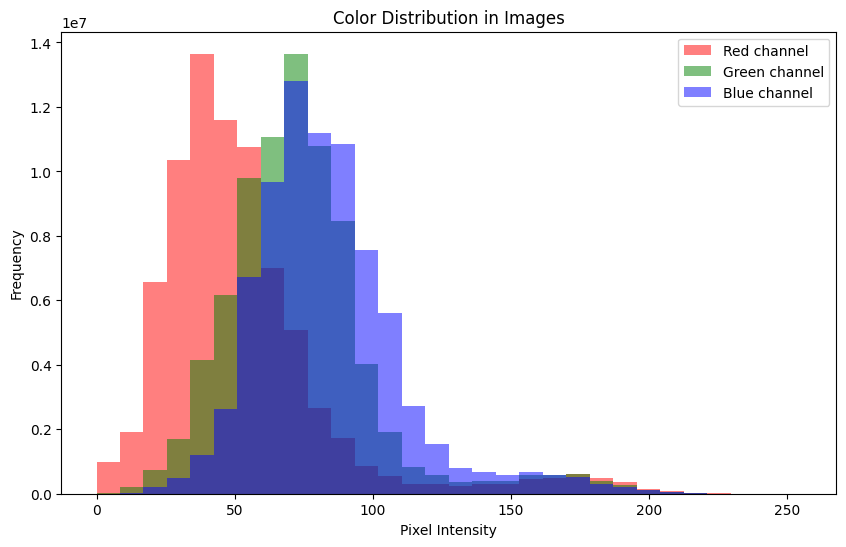

In [ ]:
def plot_color_distribution(images):
    # Assuming images are in RGB format
    red_values = images[:,:,:,0].flatten()
    green_values = images[:,:,:,1].flatten()
    blue_values = images[:,:,:,2].flatten()

    plt.figure(figsize=(10, 6))
    plt.hist(red_values, bins=30, color='red', alpha=0.5, label='Red channel')
    plt.hist(green_values, bins=30, color='green', alpha=0.5, label='Green channel')
    plt.hist(blue_values, bins=30, color='blue', alpha=0.5, label='Blue channel')
    plt.title('Color Distribution in Images')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

plot_color_distribution(images)

The Red channel is skewed toward lower intensity meaning that the color isn't as present as green and blue.

####1. Loose Silky-Bent

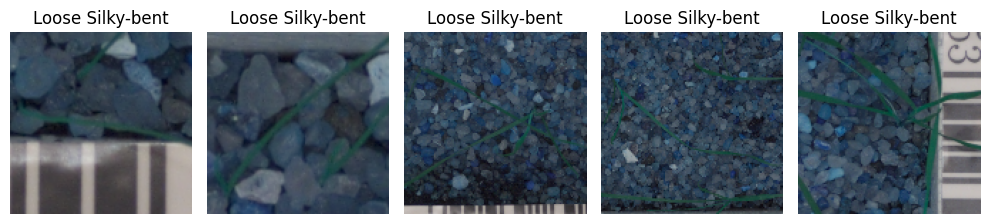

In [ ]:
show_images('Loose Silky-bent')

####2. Common Chickweed

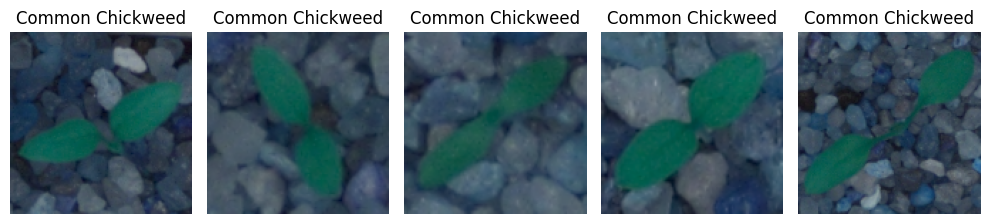

In [ ]:
show_images('Common Chickweed')

####3. Scentless Mayweed

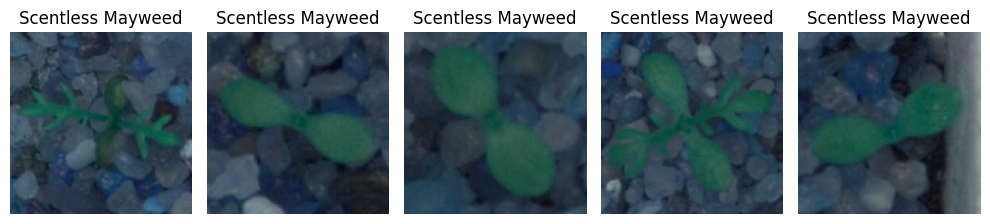

In [ ]:
show_images('Scentless Mayweed')

####4. Small-flowered Cranesbill

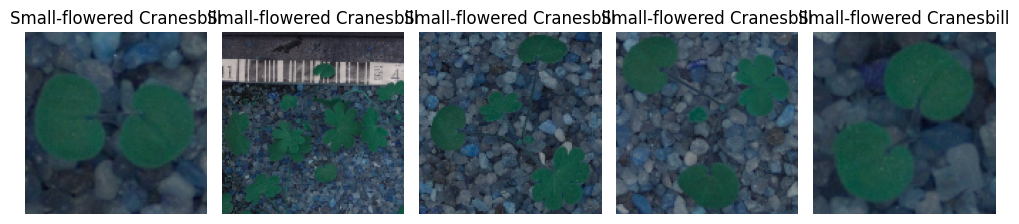

In [ ]:
show_images('Small-flowered Cranesbill')

####5. Fat Hen

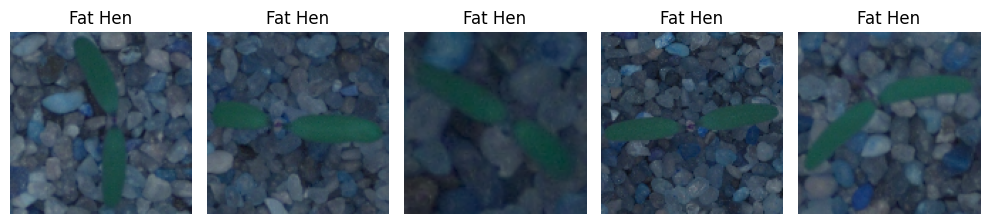

In [ ]:
show_images('Fat Hen')

####6. Charlock

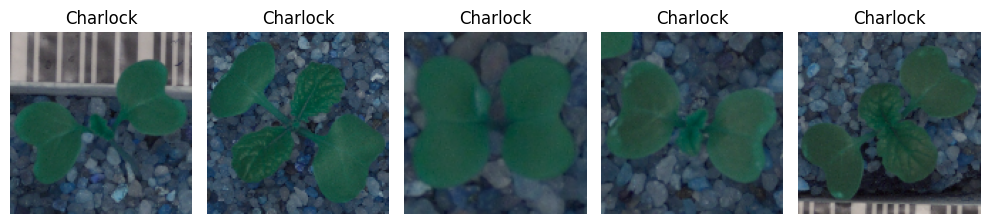

In [ ]:
show_images('Charlock')

####7.Sugar beet

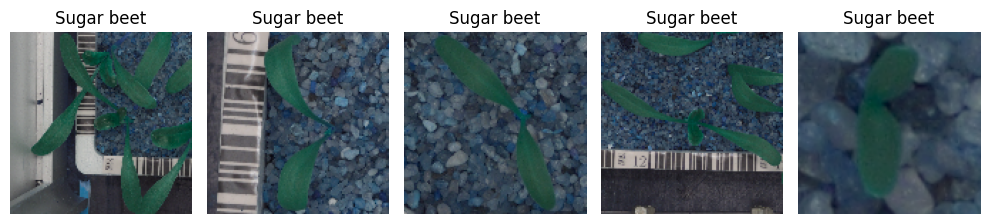

In [ ]:
show_images('Sugar beet')

####8. Cleavers

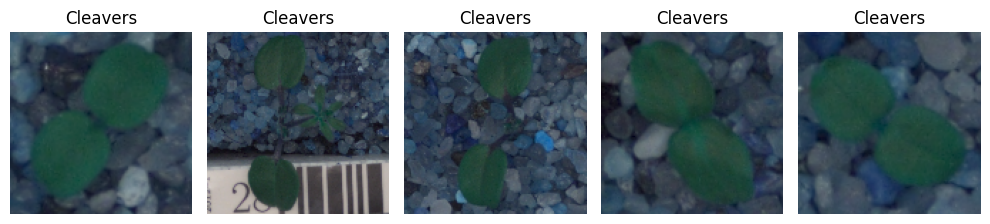

In [ ]:
show_images('Cleavers')

####9. Black-grass

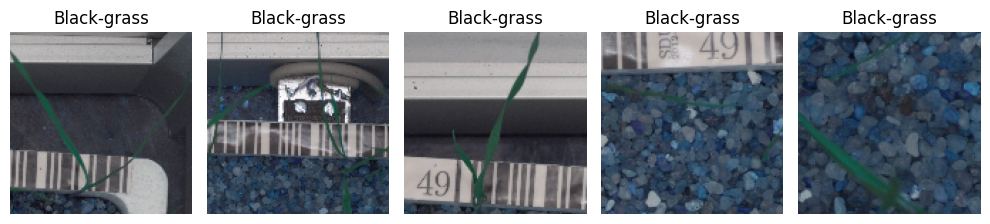

In [ ]:
show_images('Black-grass')

####10. Shepherds Purse

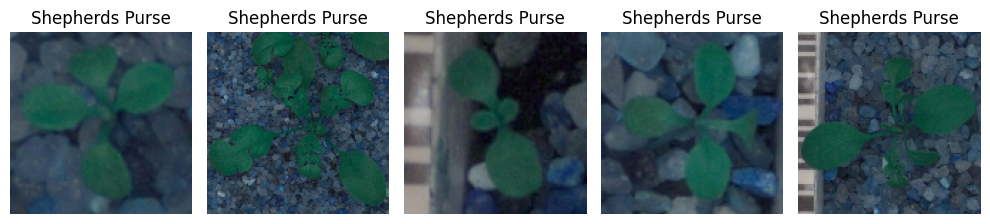

In [ ]:
show_images('Shepherds Purse')

####11. Common wheat

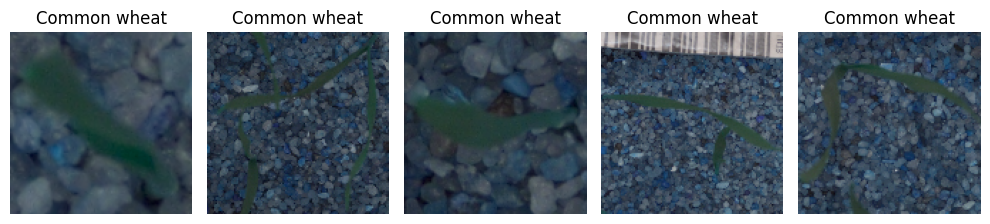

In [ ]:
show_images('Common wheat')

####12. Maize

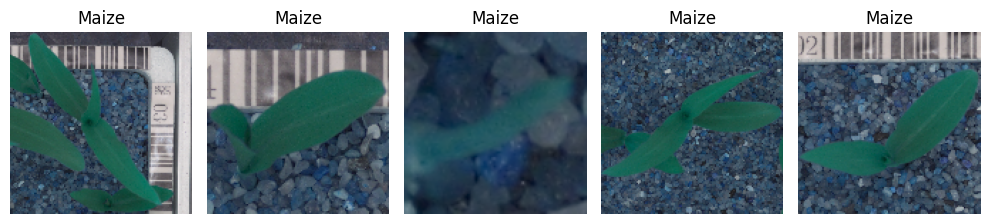

In [ ]:
show_images('Maize')

## Data Pre-Processing

### Convert the BGR images to RGB images.

In [ ]:
# Convert the images from BGR to RGB using OpenCV's cvtColor function
for i in range(len(images)):
  images[i] = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)

### Resize the images

As the size of the images is large, it may be computationally expensive to train on these larger images; therefore, it is preferable to reduce the image size from 128 to 64.

In [ ]:

decreased_image_size=[]
height = 64
width =  64
dimensions = (width, height)
for i in range(len(images)):
  decreased_image_size.append(cv2.resize(images[i], dimensions, interpolation=cv2.INTER_LINEAR))

###Image (Before)

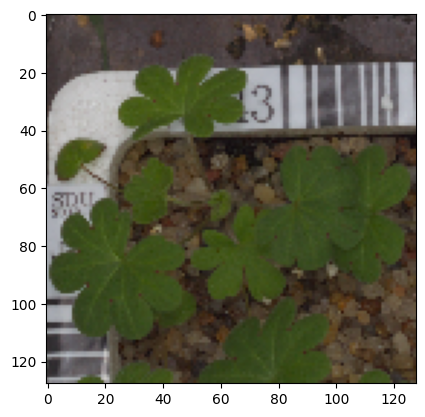

In [ ]:
plt.imshow(images[3])

Image (After)

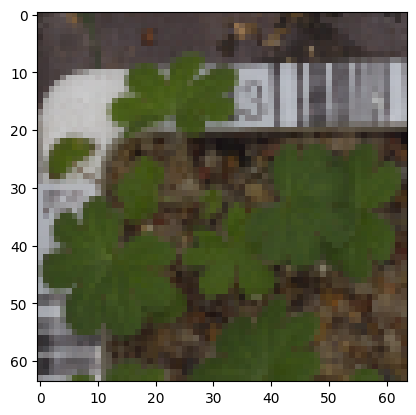

In [ ]:
plt.imshow(decreased_image_size[3])

### Data Preparation for Modeling

- Before you proceed to build a model, you need to split the data into train, test, and validation to be able to evaluate the model that you build on the train data
- You'll have to encode categorical features and scale the pixel values.
- You will build a model using the train data and then check its performance

**Split the dataset**

In [ ]:
# Split the data into temporary training+validation sets and test sets with test_size as 0.1
X_temp, X_test, y_temp, y_test = train_test_split(np.array(decreased_image_size), labels, test_size=0.1, random_state=42, stratify=labels)

# Split the temporary training+validation sets into final training and validation sets with test_size as 0.1
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1, random_state=42, stratify=y_temp)

In [ ]:
# print the shape of the training, test, and validation data sets.
print(X_train.shape,y_train.shape)
print(X_val.shape,y_val.shape)
print(X_test.shape,y_test.shape)
print(X_temp.shape,y_temp.shape)

(3847, 64, 64, 3) (3847, 1)
(428, 64, 64, 3) (428, 1)
(475, 64, 64, 3) (475, 1)
(4275, 64, 64, 3) (4275, 1)


### Encode the target labels

In [ ]:
# Convert labels from names to one-hot vectors.
enc = LabelBinarizer()
y_train_encoded = enc.fit_transform(y_train)
y_val_encoded=enc.transform(y_val)
y_test_encoded=enc.transform(y_test)

In [ ]:
y_train_encoded.shape,y_val_encoded.shape,y_test_encoded.shape

((3847, 12), (428, 12), (475, 12))

### Data Normalization

In [ ]:
# Normalize the image pixels of the train, test and validation data
X_train_normalized = X_train.astype('float32')/255.0
X_val_normalized = X_val.astype('float32')/255.0
X_test_normalized = X_test.astype('float32')/255.0

## Model Building

In [ ]:
# Clearing backend / delete all the existing models and layers to free up memory and resources
backend.clear_session()

In [ ]:
''' Ensure that the same results are
    returned from random number selection'''

# Planting a seed for random number generators
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [ ]:
# Initiale a sequential model
model1 = Sequential()

# First convolutional layer with 128 filters, kernel size 3x3, activation 'relu', padding 'same', input shape (64, 64, 3)
model1.add(Conv2D(128, (3, 3), activation='relu', padding="same", input_shape=(64, 64, 3)))

# Max pooling to reduce the size of output of first conv layer
model1.add(MaxPooling2D((2, 2), padding='same'))

# Two similar convolution and max-pooling layers with activation 'relu'
model1.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
model1.add(MaxPooling2D((2, 2), padding='same'))

model1.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model1.add(MaxPooling2D((2, 2), padding='same'))

# Flatten the output of the convolutional layer after max pooling to make it ready for creating dense connections
model1.add(Flatten())

# A fully connected dense layer with 16 neurons
model1.add(Dense(16, activation='relu'))
model1.add(Dropout(0.3))

# The output layer with 12 neurons and activation function 'softmax' for multi-class classification
model1.add(Dense(12, activation='softmax'))

# Use the Adam optimizer
opt = Adam()

# Compile the model using 'categorical_crossentropy' as the loss function (suitable for multi-class classification)
model1.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Generate a summary of the model
model1.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 128)       3584      
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 128)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        73792     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 32)        18464     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 8, 8, 32)          0

###Fit Model on Train Data

In [ ]:
# Fit the model on train and use the validation data for validation
history_1 = model1.fit(
            X_train_normalized, y_train_encoded,
            epochs=30,
            validation_data=(X_val_normalized,y_val_encoded),
            batch_size=32,
            verbose=2
)

Epoch 1/30
121/121 - 8s - loss: 2.4523 - accuracy: 0.1123 - val_loss: 2.4377 - val_accuracy: 0.1285 - 8s/epoch - 69ms/step
Epoch 2/30
121/121 - 1s - loss: 2.3348 - accuracy: 0.1999 - val_loss: 2.0167 - val_accuracy: 0.3621 - 1s/epoch - 9ms/step
Epoch 3/30
121/121 - 1s - loss: 2.0563 - accuracy: 0.2805 - val_loss: 1.8277 - val_accuracy: 0.3832 - 1s/epoch - 10ms/step
Epoch 4/30
121/121 - 1s - loss: 1.9288 - accuracy: 0.3169 - val_loss: 1.7755 - val_accuracy: 0.3902 - 1s/epoch - 10ms/step
Epoch 5/30
121/121 - 1s - loss: 1.8370 - accuracy: 0.3299 - val_loss: 1.7576 - val_accuracy: 0.3879 - 1s/epoch - 10ms/step
Epoch 6/30
121/121 - 1s - loss: 1.7928 - accuracy: 0.3410 - val_loss: 1.5617 - val_accuracy: 0.4439 - 1s/epoch - 10ms/step
Epoch 7/30
121/121 - 1s - loss: 1.7450 - accuracy: 0.3569 - val_loss: 1.5098 - val_accuracy: 0.4720 - 1s/epoch - 10ms/step
Epoch 8/30
121/121 - 1s - loss: 1.6794 - accuracy: 0.3631 - val_loss: 1.4088 - val_accuracy: 0.5093 - 1s/epoch - 10ms/step
Epoch 9/30
121/12

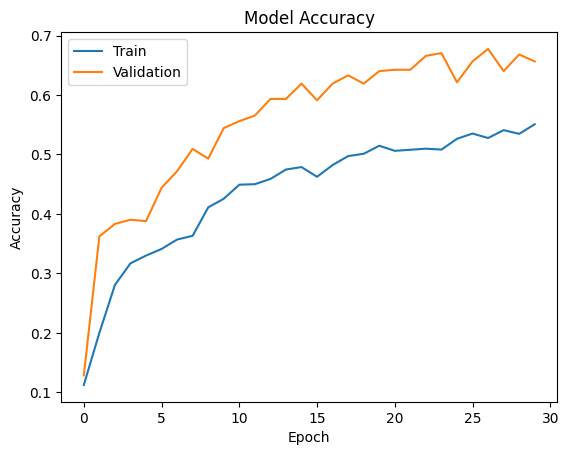

In [ ]:
# Plot the
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

**Summary:**

The model's training accuracy starts low and improves without pleateauing. This indicates that the model was still learning. The validation accuracy also starts low and increases from epoch 1 through epoch 30.

The loss function is improving throughout the itterative cycle, as expected.

###Evaluate Model on Test **Data**

In [ ]:
# Evaluate the model on the test data
test_loss, test_accuracy = model1.evaluate(X_test_normalized, y_test_encoded, verbose=2)
print(f"Test accuracy: {test_accuracy}")

15/15 - 0s - loss: 1.0677 - accuracy: 0.6737 - 333ms/epoch - 22ms/step
Test accuracy: 0.6736842393875122


**Test Evaluation Summary:**

This model performed at around 67% accuracy--which is not great. Given that the images used to test each plant were taken in a controlled setting, we should strive for something much more accurate.

The Test data accuracy and the Validation data accuracy are not drastically different. This probably indicates that the model is not overfit.

The loss function (1.0677) indicates plenty of room for improvement.

In [ ]:
# Predicting the probabilities for the test data
y_pred = model1.predict(X_test_normalized)

15/15 [==============================] - 0s 3ms/step


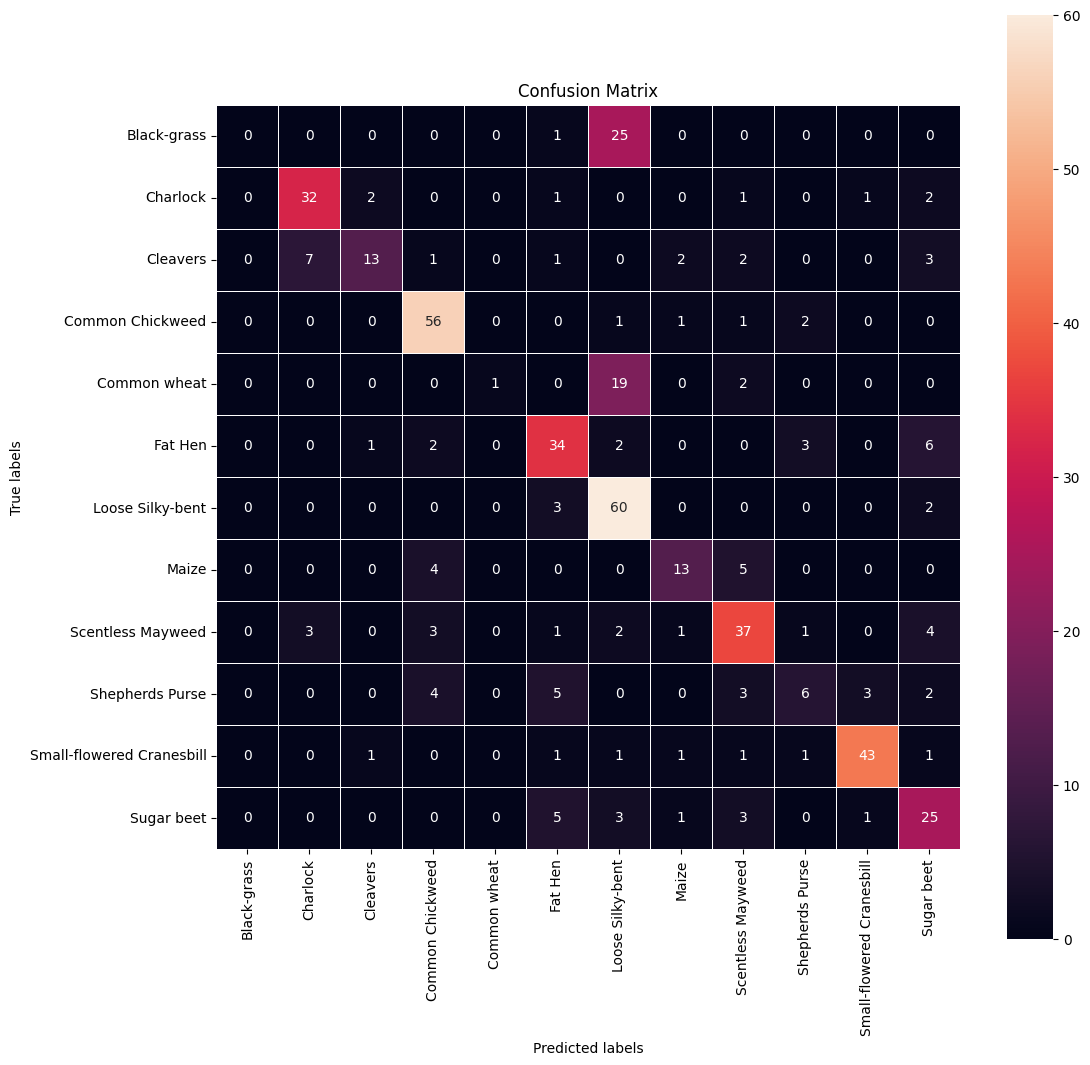

In [ ]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_pred,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function
confusion_matrix = tf.math.confusion_matrix(y_test_arg, y_pred_arg)
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.5,
    fmt="d",
    square=True,
    ax=ax
)
# Setting the labels to both the axes
ax.set_xlabel('Predicted labels'); ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(list(enc.classes_), rotation=90)
ax.yaxis.set_ticklabels(list(enc.classes_), rotation=0)
plt.show()

**Summary of Classification Performance:**



*   The 'Black-grass' plant class was never correctly predicted
*   'Charlock' has a relatively high number of correct predictions (30), with a few instances where it was confused with 'Cleavers' and 'Common Chickweed'.
*   'Loose Silky-Bent' is the class with the highest correct predictions (60), but it is also the most frequent class which is confused with the others.

*Overall, the model performs well for some classes and struggles with others. Note that the best performing varieties are associated with a class imbalance in their favor (more images of those classes than there are of the classes that did not perform well).*


In [ ]:
# Get class names from the enc label encoder
class_names = enc.classes_

# Generate the classification report with class names
cr = metrics.classification_report(y_test_arg, y_pred_arg, target_names=class_names)

# Print the classification report
print(cr)

                           precision    recall  f1-score   support

              Black-grass       0.00      0.00      0.00        26
                 Charlock       0.76      0.82      0.79        39
                 Cleavers       0.76      0.45      0.57        29
         Common Chickweed       0.80      0.92      0.85        61
             Common wheat       1.00      0.05      0.09        22
                  Fat Hen       0.65      0.71      0.68        48
         Loose Silky-bent       0.53      0.92      0.67        65
                    Maize       0.68      0.59      0.63        22
        Scentless Mayweed       0.67      0.71      0.69        52
          Shepherds Purse       0.46      0.26      0.33        23
Small-flowered Cranesbill       0.90      0.86      0.88        50
               Sugar beet       0.56      0.66      0.60        38

                 accuracy                           0.67       475
                macro avg       0.65      0.58      0.57    

**Model Review and Performance Analysis:**

As seen from the confusion matrix, some classifications did not perform well while others performed fairly well.

## Model Performance Improvement

**Reducing the Learning Rate:**

**Hint**: Use **ReduceLRonPlateau()** function that will be used to decrease the learning rate by some factor, if the loss is not decreasing for some time. This may start decreasing the loss at a smaller learning rate. There is a possibility that the loss may still not decrease. This may lead to executing the learning rate reduction again in an attempt to achieve a lower loss.

In [ ]:
# Code to monitor val_accuracy
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

### **Data Augmentation**

Remember, **data augmentation should not be used in the validation/test data set**.

In [ ]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()

# Fixing the seed for random number generators
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [ ]:
train_datagen = ImageDataGenerator(
                              rotation_range=20,
                              fill_mode='nearest'
                              )

In [ ]:
# Initializing a sequential model
model2 = Sequential()

# Adding the first conv layer with 64 filters, kernel size 3x3, activation 'relu', padding 'same', input shape (64, 64, 3)
model2.add(Conv2D(64, (3, 3), activation='relu', padding="same", input_shape=(64, 64, 3)))

# Adding max pooling to reduce the size of output of first conv layer
model2.add(MaxPooling2D((2, 2), padding='same'))

# Continuing with the model layers
model2.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model2.add(MaxPooling2D((2, 2), padding='same'))
model2.add(BatchNormalization())

# Flattening the output of the conv layer after max pooling to make it ready for creating dense connections
model2.add(Flatten())

# Adding a fully connected dense layer with 16 neurons
model2.add(Dense(16, activation='relu'))

# Adding dropout with dropout_rate=0.3
model2.add(Dropout(0.3))

# Adding the output layer with 12 neurons and activation function 'softmax' for multi-class classification
model2.add(Dense(12, activation='softmax'))

# Initializing Adam optimizer
opt = Adam()

# Compiling the model
model2.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Generating the summary of the model
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 32)        0         
 g2D)                                                            
                                                                 
 batch_normalization (Batch  (None, 16, 16, 32)        128       
 Normalization)                                                  
                                                        

###Model 2 - Fit to Train Data

In [ ]:
# Epochs
epochs = 30
# Batch size
batch_size = 64

history = model2.fit(train_datagen.flow(X_train_normalized, y_train_encoded,
                                       batch_size=batch_size,
                                       shuffle=False),
                                       epochs=epochs,
                                       steps_per_epoch=X_train_normalized.shape[0] // batch_size,
                                       validation_data=(X_val_normalized,y_val_encoded),
                                       verbose=1,callbacks=[learning_rate_reduction])

Epoch 1/30
60/60 [==============================] - 9s 106ms/step - loss: 2.1344 - accuracy: 0.2448 - val_loss: 2.3955 - val_accuracy: 0.1822 - lr: 0.0010
Epoch 2/30
60/60 [==============================] - 4s 70ms/step - loss: 1.6526 - accuracy: 0.4296 - val_loss: 2.2484 - val_accuracy: 0.3037 - lr: 0.0010
Epoch 3/30
60/60 [==============================] - 5s 78ms/step - loss: 1.4379 - accuracy: 0.5017 - val_loss: 2.2077 - val_accuracy: 0.2687 - lr: 0.0010
Epoch 4/30
60/60 [==============================] - 5s 89ms/step - loss: 1.3751 - accuracy: 0.5168 - val_loss: 2.1287 - val_accuracy: 0.5654 - lr: 0.0010
Epoch 5/30
60/60 [==============================] - 4s 71ms/step - loss: 1.2686 - accuracy: 0.5488 - val_loss: 1.8012 - val_accuracy: 0.4463 - lr: 0.0010
Epoch 6/30
60/60 [==============================] - 6s 94ms/step - loss: 1.1686 - accuracy: 0.5784 - val_loss: 1.7626 - val_accuracy: 0.5864 - lr: 0.0010
Epoch 7/30
60/60 [==============================] - 4s 70ms/step - loss: 1.

####Model Evaluation:

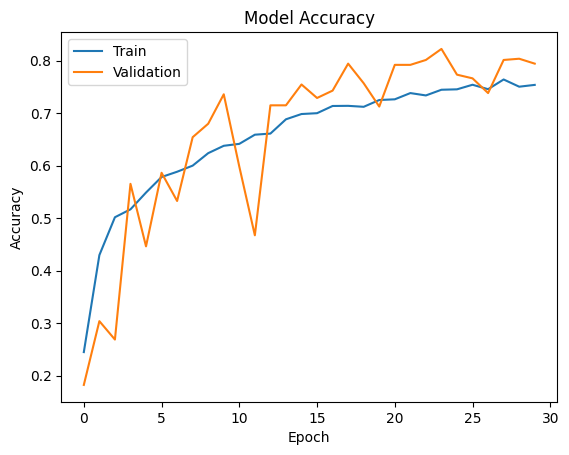

In [ ]:
# Evaluate the model accuray
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

**Summary:**

Training Accuracy: The model's training accuracy improves with each training epoch (~75%)

Validation Accuracy: The validation accuracy has irregular spikes in the accuracy. This could be due to sensitivity to specific training images.

####Evaluate the Model of Test Data

In [ ]:
# Evaluate the model on the test data
test_loss, test_accuracy = model2.evaluate(X_test_normalized, y_test_encoded, verbose=2)
print(f"Test accuracy: {test_accuracy}")

15/15 - 0s - loss: 0.7460 - accuracy: 0.7642 - 226ms/epoch - 15ms/step
Test accuracy: 0.7642105221748352


**Test Evaluation Summary:**

This model performed at around 76% accuracy. This is better than the previous model's performance but still not ideal.

The Test data accuracy (.7642) and the Validation data accuracy (.7642) are the same. This probably indicates that the model is not overfit.

The loss function (.7460) indicates significant improvement from the previous model.

In [ ]:
y_pred2=model2.predict(X_test_normalized)

15/15 [==============================] - 0s 2ms/step


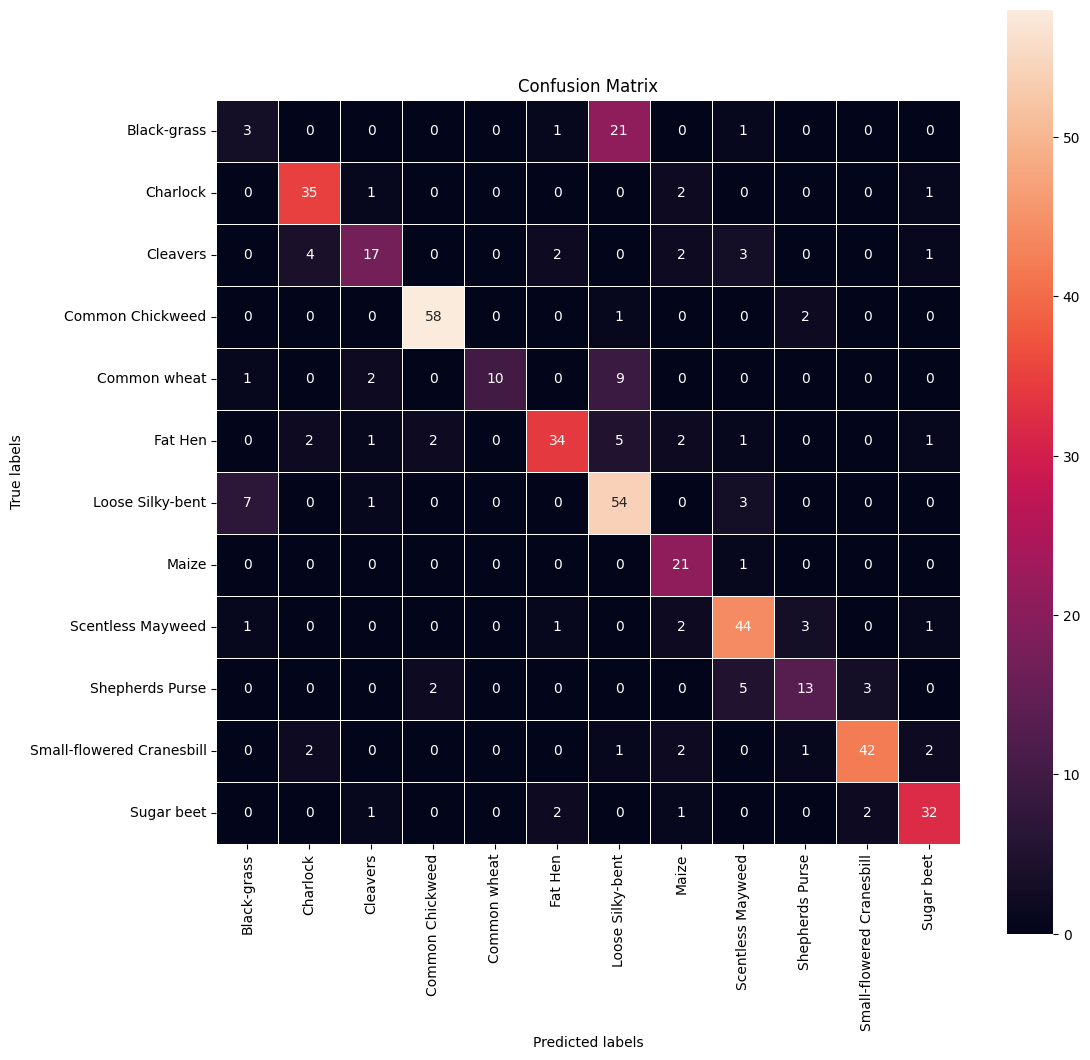

In [ ]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred2_arg=np.argmax(y_pred2,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function
confusion_matrix = tf.math.confusion_matrix(y_test_arg, y_pred2_arg)
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.5,
    fmt="d",
    square=True,
    ax=ax
)
# Setting the labels to both the axes
ax.set_xlabel('Predicted labels'); ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(list(enc.classes_), rotation=90)
ax.yaxis.set_ticklabels(list(enc.classes_), rotation=0)
plt.show()

**Summary of Classification Performance:**

*   The 'Black-grass' plant now shows some correct predictions
*   Generally, the classes were predicted with higher accuracy acorss the board




In [ ]:
# Get class names from the enc label encoder
class_names = enc.classes_

# Generate the classification report with class names
cr = metrics.classification_report(y_test_arg, y_pred2_arg, target_names=class_names)

# Print the classification report
print(cr)

                           precision    recall  f1-score   support

              Black-grass       0.25      0.12      0.16        26
                 Charlock       0.81      0.90      0.85        39
                 Cleavers       0.74      0.59      0.65        29
         Common Chickweed       0.94      0.95      0.94        61
             Common wheat       1.00      0.45      0.62        22
                  Fat Hen       0.85      0.71      0.77        48
         Loose Silky-bent       0.59      0.83      0.69        65
                    Maize       0.66      0.95      0.78        22
        Scentless Mayweed       0.76      0.85      0.80        52
          Shepherds Purse       0.68      0.57      0.62        23
Small-flowered Cranesbill       0.89      0.84      0.87        50
               Sugar beet       0.84      0.84      0.84        38

                 accuracy                           0.76       475
                macro avg       0.75      0.72      0.72    

**Model Review and Performance Analysis:**

The overall performance (recal, precision, etc.) have shown improvement across the board, albeit, still not to a standard that a professional services organization could rely upon.

## Final Model

The final model selected will be the the **Augemented Data** model. This model had the best metric scores.

### Visualizing the prediction

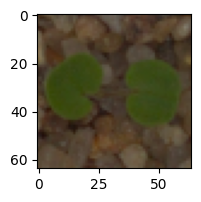

1/1 [==============================] - 0s 32ms/step
Predicted Label ['Small-flowered Cranesbill']
True Label Small-flowered Cranesbill


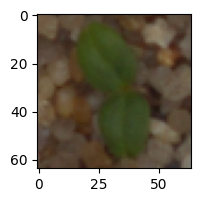

1/1 [==============================] - 0s 30ms/step
Predicted Label: ['Scentless Mayweed']
Actual Label: Scentless Mayweed


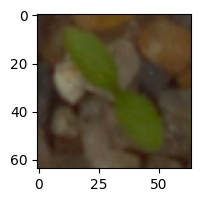

1/1 [==============================] - 0s 65ms/step
Predicted Label: ['Common Chickweed']
Actual Label: Common Chickweed


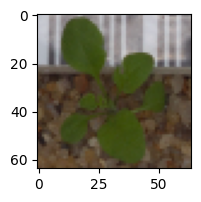

1/1 [==============================] - 0s 52ms/step
Predicted Label: ['Shepherds Purse']
Actual Label: Shepherds Purse


In [ ]:

# Visualizing the predicted and correct label of images from test data
plt.figure(figsize=(2,2))
plt.imshow(X_test[2])
plt.show()
## Complete the code to predict the test data using the final model selected
print('Predicted Label', enc.inverse_transform(model2.predict((X_test_normalized[2].reshape(1,64,64,3)))))   # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[2])                                               # using inverse_transform() to get the output label from the output vector

plt.figure(figsize=(2,2))
plt.imshow(X_test[33])
plt.show()
## Complete the code to predict the test data using the final model selected
print('Predicted Label:', enc.inverse_transform(model2.predict((X_test_normalized[90].reshape(1,64,64,3)))))  # reshaping the input image as we are only trying to predict using a single image
print('Actual Label:', enc.inverse_transform(y_test_encoded)[90])                                              # using inverse_transform() to get the output label from the output vector

plt.figure(figsize=(2,2))
plt.imshow(X_test[59],)
plt.show()
## Complete the code to predict the test data using the final model selected
print('Predicted Label:', enc.inverse_transform(model2.predict((X_test_normalized[59].reshape(1,64,64,3)))))  # reshaping the input image as we are only trying to predict using a single image
print('Actual Label:', enc.inverse_transform(y_test_encoded)[59])                                              # using inverse_transform() to get the output label from the output vector

plt.figure(figsize=(2,2))
plt.imshow(X_test[36])
plt.show()
## Complete the code to predict the test data using the final model selected
print('Predicted Label:', enc.inverse_transform(model2.predict((X_test_normalized[36].reshape(1,64,64,3)))))  # reshaping the input image as we are only trying to predict using a single image
print('Actual Label:', enc.inverse_transform(y_test_encoded)[36])                                              # using inverse_transform() to get the output label from the output vector

In the sampled predictions (above), the predictions were 100% accurate.

## Actionable Insights and Business Recommendations

**Insights:**

* The model is only predicting with an accuracy rate of ~76%. This means that a quarter of the predictoins are expected to be incorrect. However, some insight on where the model gets things wrong is given.
    * Black Grass has more incorrect predictions than correct predictions.
    * Loose Silky-bend has the highest number of correct and incorrect predictions.
    * If the model did not have to predict Loose Silky-bend or Black Grass varieties, the overall accuracy would ~88.8%. This is bordering on an acceptable production level of predictions.

**Recommendations:**

1. The business could consider mannually verifying all 'Black Grass' predictions. As there were a significant number of black predictions given to that class which were incorrect. Doing so, would increase the accuracy of the business's overall classification strategy but would not improve the model.

2. Or, the business could invest in additional training for the model. At a minimum, this wthraining would focus on additional training for both the 'Black Grass' and 'Loose Silky-bend' varieties so that the model's overal accuracy is increased. It's possible that the model could benefit from a **Transfer Learning** approach.

_____